In [38]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [134]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tristanzhang32/ai-generated-images-vs-real-images")


In [135]:
os.listdir(path)

['test', 'train']

In [5]:
len(os.listdir(os.path.join(path, "test", "real")))
for f in os.listdir(os.path.join(path, "test", "real")):
    if not f.endswith(".jpg"):
        print(f)

In [132]:
folder = os.listdir(os.path.join(path, "test", "fake"))
len(folder)

files=[f for f in folder if not f.endswith((".jpg"))]
len(files)

2121

In [7]:
folder = os.listdir(os.path.join(path, "train", "fake"))
len(folder)
files=[f for f in folder if not f.endswith((".jpg", ".png"))]
len(files)

0

In [133]:
len(os.listdir(os.path.join(path, "train", "real")))
# for f in os.listdir(os.path.join(path, "train", "real")):
#     if not f.endswith(".jpg"):
#         print(f)
#os.listdir(os.path.join(path, "test", "real"))

24000

w datasecie mamy:

6000 obrazów w test/fake, a niektóre z nich są .png

6000 obrazów w test/real, wszystkie są .jpg

24000 obrazów w train/fake, a niektóre z nich to .png

24000 obrazów w train/real, wszystkie .jpg


In [9]:
img_size=(128, 128)
img=tf.io.read_file(os.path.join(path, "test", "fake", "0002.jpg"))
img=tf.image.decode_image(img, channels=3)
img=tf.image.resize(img, img_size)
img=img/255.0

(128, 128, 3)


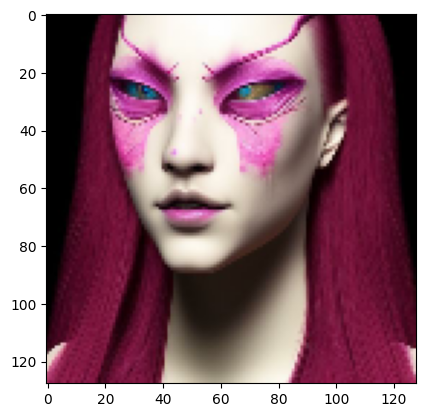

In [10]:
plt.imshow(img)
print(img.shape)


Załadowanie danych

(zebranie ścieżek i etykiet)

In [123]:
def get_paths(tt):
    full_paths=glob.glob(os.path.join(path, tt, "*/*.*"))
    labels=[path.split(os.path.sep)[-2] for path in full_paths]
    return full_paths, labels
train_paths, train_labels=get_paths("train")
test_paths, test_labels=get_paths("test")

Kodowanie etykiet 

In [91]:
le=LabelEncoder()
le.fit(train_labels)

y_train=le.transform(train_labels)
y_test=le.transform(test_labels)

Dodanie zbioru walidacyjnego

In [92]:
train_paths_x, x_val, train_labels_y, y_val=train_test_split(train_paths, y_train, test_size=0.2, stratify=train_labels, random_state=42)

Przetworzenie obrazów

In [99]:
img_size=(128, 128)

def process_image(file_path, label):
    img=tf.io.read_file(file_path)
    img=tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img=tf.image.resize(img, img_size)
    img=tf.cast(img, tf.float32)/255.0
    return img, label, file_path


Tworzenie pipeline

Dane treningowe:

In [94]:
ds_train=tf.data.Dataset.from_tensor_slices((train_paths_x, train_labels_y))
ds_train=ds_train.map(process_image, num_parallel_calls= tf.data.AUTOTUNE).ignore_errors().cache("train_cache").shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)


Dane do walidacji:

In [95]:
ds_val=tf.data.Dataset.from_tensor_slices((x_val, y_val))
ds_val=ds_val.map(process_image, num_parallel_calls= tf.data.AUTOTUNE).ignore_errors().cache().batch(32).prefetch(tf.data.AUTOTUNE)


Dane testowe:

In [129]:
test_paths = np.array(test_paths)
y_test = np.array(y_test)

indices = np.arange(len(test_paths))
np.random.seed(42)
np.random.shuffle(indices)

shuffled_test_paths = test_paths[indices]
shuffled_y_test = y_test[indices]

In [130]:
ds_test = tf.data.Dataset.from_tensor_slices((shuffled_test_paths, shuffled_y_test))
ds_test = ds_test.map(process_image, num_parallel_calls=tf.data.AUTOTUNE).ignore_errors().batch(32).prefetch(tf.data.AUTOTUNE)


Model:

In [27]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,438,883 (28.38 MB)

 Trainable params: 7,438,883 (28.38 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(ds_train,
          validation_data=ds_val,
            epochs=10)


Epoch 1/10
   1200/Unknown 853s 699ms/step - accuracy: 0.6078 - loss: 0.6820

c:\Users\embra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1200/1200 ━━━━━━━━━━━━━━━━━━━━ 1009s 828ms/step - accuracy: 0.6666 - loss: 0.6134 - val_accuracy: 0.7456 - val_loss: 0.5265
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 437s 364ms/step - accuracy: 0.7702 - loss: 0.4895 - val_accuracy: 0.8005 - val_loss: 0.4451
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 477s 397ms/step - accuracy: 0.8132 - loss: 0.4169 - val_accuracy: 0.8095 - val_loss: 0.4466
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 621s 517ms/step - accuracy: 0.8365 - loss: 0.3776 - val_accuracy: 0.7559 - val_loss: 0.5774
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 21457s 18s/step - accuracy: 0.8472 - loss: 0.3547 - val_accuracy: 0.8232 - val_loss: 0.4138
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 439s 365ms/step - accuracy: 0.8607 - loss: 0.3272 - val_accuracy: 0.8372 - val_loss: 0.4000
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 520s 433ms/step - accuracy: 0.8725 - loss: 0.3009 - val_accuracy: 0.8365 - val_loss: 0.4221
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 654s 545ms/step - accuracy: 0.

{'accuracy': [0.6665971875190735, 0.7701523900032043, 0.813204824924469, 0.8365151882171631, 0.8471676111221313, 0.8607370853424072, 0.8725354671478271, 0.8816512823104858, 0.8919650912284851, 0.8986847400665283], 'loss': [0.6134421229362488, 0.4894981384277344, 0.4169403612613678, 0.3776001036167145, 0.35472920536994934, 0.32715529203414917, 0.300875186920166, 0.2809390723705292, 0.25955450534820557, 0.24290160834789276], 'val_accuracy': [0.7455966472625732, 0.8005210757255554, 0.8094841241836548, 0.7559145092964172, 0.8232412934303284, 0.8372069001197815, 0.8364773392677307, 0.8365815281867981, 0.8479416370391846, 0.8317874073982239], 'val_loss': [0.5265135765075684, 0.44507870078086853, 0.4465833604335785, 0.577439546585083, 0.4138301908969879, 0.4000193476676941, 0.4220660626888275, 0.4332038462162018, 0.4124879837036133, 0.4479157328605652]}


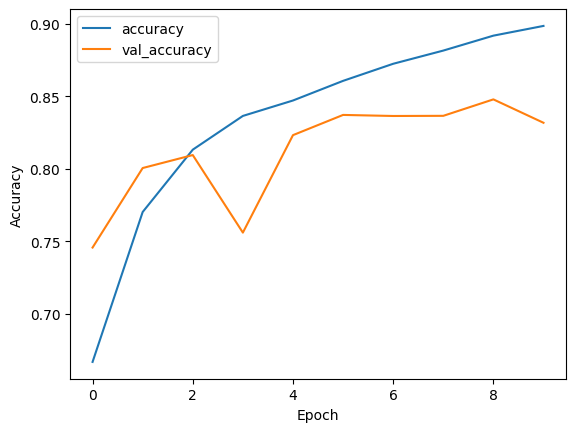

In [32]:
print(history.history)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

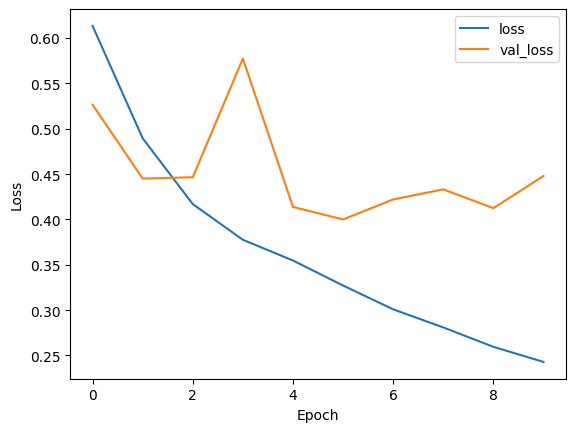

In [34]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Filtry: (3, 3, 3, 32)


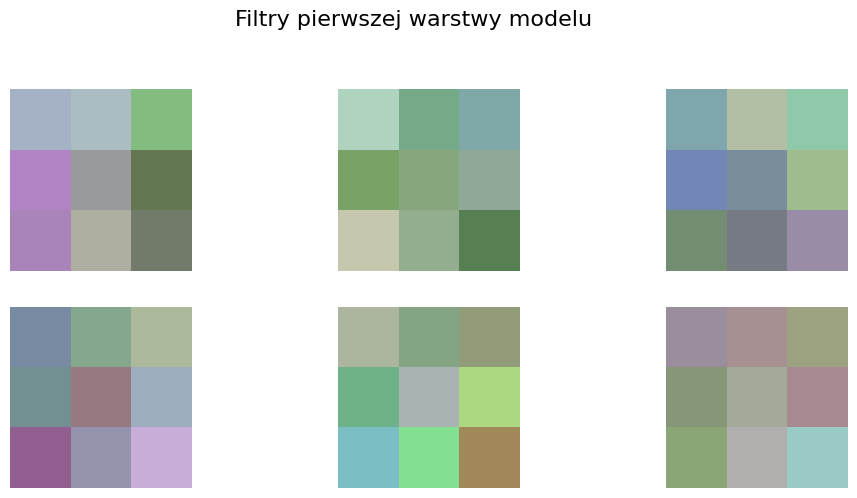

In [55]:
filters, biases = model.layers[0].get_weights()

print("Filtry:", filters.shape)

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 6
plt.figure(figsize=(12, 8))

for i in range(n_filters):
    f = filters[:, :, :, i]
    plt.subplot(3, 3, i+1)
    plt.imshow(f)
    plt.axis('off')

plt.suptitle("Filtry pierwszej warstwy modelu", fontsize=16)
plt.show()

In [126]:
predictions = model.predict(ds_test)


375/375 ━━━━━━━━━━━━━━━━━━━━ 184s 489ms/step


c:\Users\embra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [131]:
predict_labels=tf.argmax(predictions, axis=1)
true_labels = np.concatenate([y.numpy() for _, y, _ in ds_test])


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_labels, predict_labels))
cm = confusion_matrix(true_labels, predict_labels)
print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      6000
           1       0.89      0.78      0.83      5997

    accuracy                           0.84     11997
   macro avg       0.85      0.84      0.84     11997
weighted avg       0.85      0.84      0.84     11997



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


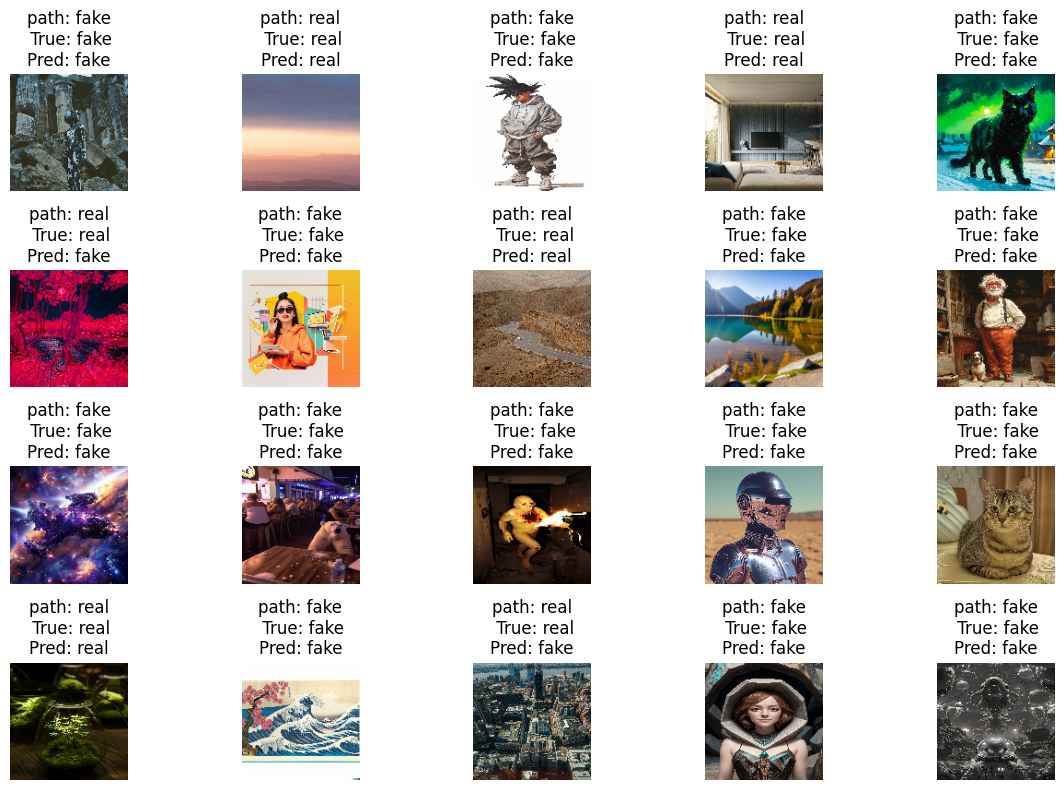

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


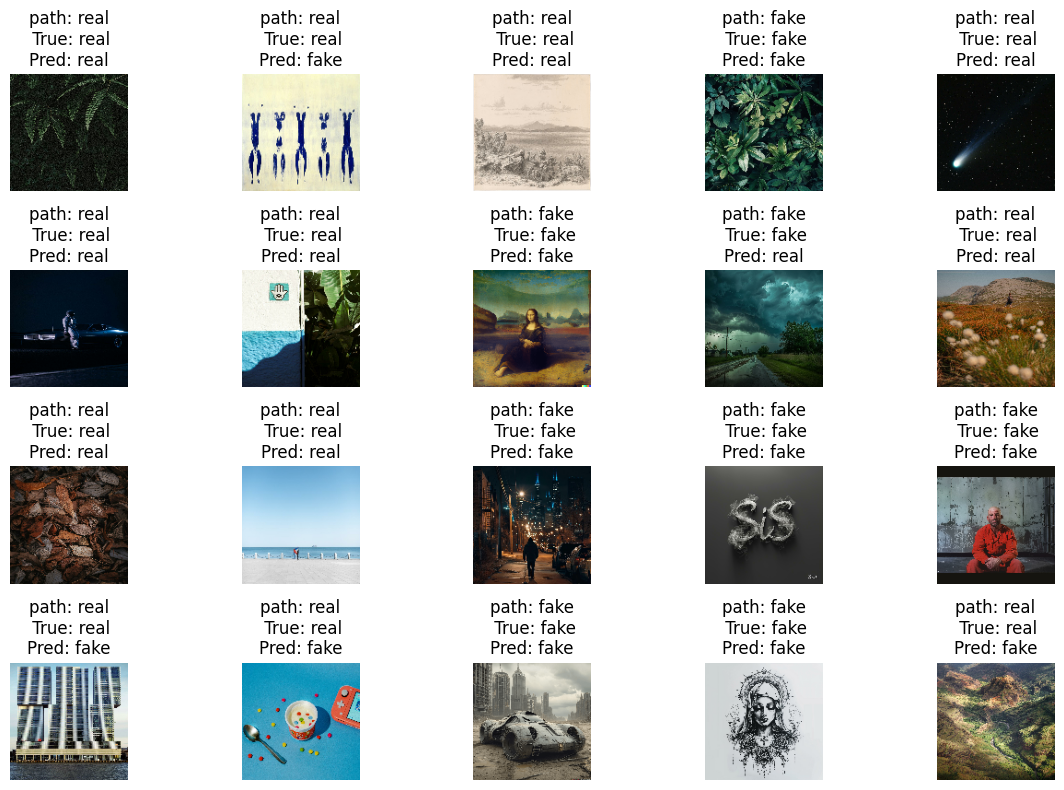

In [111]:
for image, label, test_paths in ds_test.take(2):
    preds = model.predict(image)
    pred_labels = tf.argmax(preds, axis=1)
    
    plt.figure(figsize=(12, 8))
    for i in range(20):
        img_path = test_paths[i].numpy().decode("utf-8")
        plt.subplot(4, 5, i+1)
        plt.imshow(image[i].numpy())
        plt.title(f"path: {img_path.split(os.path.sep)[-2]}\n True: {le.inverse_transform([label[i].numpy()])[0]}\nPred: {le.inverse_transform([pred_labels[i].numpy()])[0]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()